## LeNet implementation in PyTorch 🏋🏻

1. Load MNIST dataset
2. Create ConvNet (LeNet)
3. Train model
4. Evaluate model

---

### 1. Load MNIST dataset

In [34]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import v2

In [35]:
transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST(
    "./data", train=True, transform=transforms, download=True
)
validation_set = torchvision.datasets.MNIST(
    "./data", train=False, transform=transforms, download=True
)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)


In [36]:
data_iter = iter(training_loader)
images, labels = next(data_iter)
print(f"{images.shape=}; {labels=}")

images.shape=torch.Size([4, 1, 28, 28]); labels=tensor([9, 2, 7, 4])


So, we have a batch of 4 images and their labels are `5, 8, 3, 8`.

### Let's visualize them.

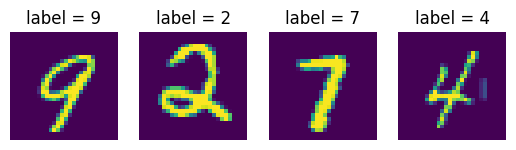

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4)  # 1 row & 4 column

for i in range(4):
    ax[i].imshow(images[i].permute(1, 2, 0))
    ax[i].set_title(f"label = {labels[i]}")
    ax[i].axis('off')

plt.show()

---

### 2. Now, let's recreate `LeNet-5` ConvNet architecture.

![LeNet](../00_assets/LeNet.png)

In [42]:
class LeNetModel(nn.Module):
    def __init__(self):
        super(LeNetModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.relu(y)
        y = self.fc3(y)
        y = self.relu(y)
        return y

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LeNetModel().to(device)
sgd = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_fn = torch.nn.CrossEntropyLoss()

---

### 3. Train the model

In [45]:
all_epoch = 50
prev_acc = 0
for current_epoch in range(all_epoch):
    model.train()
    print(f"Epoch: {current_epoch+1}")
    total_training_loss = 0
    for idx, (train_x, train_label) in enumerate(training_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label)
        total_training_loss += loss
        loss.backward()
        sgd.step()

    avg_training_loss = total_training_loss/(len(training_loader)*4) # batch size=4
    print(f"    average training loss: => {avg_training_loss}")

Epoch: 1


KeyboardInterrupt: 

---

### 4. Evaluate the model

In [33]:
model.eval()
correct_predictions = 0
incorrect_predictions = 0

with torch.no_grad():
    for idx, (test_x, test_label) in enumerate(validation_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x)
        predict_y = torch.argmax(predict_y, dim=1)

        correct_predictions += torch.sum(predict_y == test_label).item()
        incorrect_predictions += torch.sum(predict_y != test_label).item()

print(f"{correct_predictions=}; {incorrect_predictions=}")

correct_predictions=980; incorrect_predictions=9020
